### Loading the libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math

import NeuralNet as NN

### Loading data

In [2]:
LABEL_MAP = {
    0: 'healthy',
    1: 'tumor'
}

pixels = 64

M = pixels**2 # number of pixels (features)
C = len(LABEL_MAP.keys())

In [3]:
import os
from PIL import Image

def load(parentDir, image_size=(pixels, pixels)):
    images = []
    labels = []

    subdirs = [(os.path.join(parentDir, d), d) for d in sorted(os.listdir(parentDir)) if os.path.isdir(os.path.join(parentDir, d))]
    for subdir_path, label in subdirs:
        for filename in os.listdir(subdir_path):
            if (filename.endswith('.png') or filename.endswith('.jpg')):
                img_path = os.path.join(subdir_path, filename)
                with Image.open(img_path) as img:
                    img = img.convert('L').resize(image_size)
                    images.append(np.array(img).reshape(-1))
                labels.append(0 if label == 'h' else 1)  # Now inside the if block
    return np.array(images), np.array(labels).reshape(-1, 1)

# Load the data
images, labels = load('dataset')
print(images.shape, labels.shape)

(4434, 4096) (4434, 1)


In [4]:
from sklearn.model_selection import train_test_split

# Reshape the data
X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

NUM_TRAIN = int(0.8 * len(X_train))
NUM_VAL = len(X_train) - NUM_TRAIN

X_train, X_val = X_train[:NUM_TRAIN, :], X_train[NUM_TRAIN:, :]
Y_train, Y_val = Y_train[:NUM_TRAIN], Y_train[NUM_TRAIN:]

print(X_train.shape, X_val.shape)
print(X_test.shape)

(2837, 4096) (710, 4096)
(887, 4096)


### Defining helper functions

In [5]:
def visualize_images(images, titles: list[str], color_map: list[str] = None, figsize: tuple[int, int] = (10, 10)):
    num_displays = len(images)
    num_cells = math.ceil(math.sqrt(num_displays))
    plt.figure(figsize=figsize)
    if color_map is None: color_map = ['Greys' for _ in range(num_displays)] 

    for i in range(num_displays):
        pixels = images[i]
        image_size = int(math.sqrt(pixels.shape[0]))
        frame = pixels.reshape((image_size, image_size))

        plt.subplot(num_cells, num_cells, i + 1)
        plt.imshow(frame, cmap=color_map[i])
        plt.title(titles[i])
        plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.show()

In [6]:
def visualize_table(X: np.ndarray, Y: np.ndarray, num_display: int = 10):
    N, M = X.shape
    
    array = np.concatenate([Y, X], axis=1)

    header = ['pixel%d' % i for i in range(M)]
    header.insert(0, 'label') 
    
    df = pd.DataFrame(array, columns=header)
    df = df.set_index('label')

    df.head(num_display)
    
    return df

In [7]:
def onehot_encode(Y: np.ndarray, C: int):
    N = Y.shape[0] 
    Y = Y.flatten()
    onehot_Y = np.zeros((N, C))
    onehot_Y[np.arange(N), Y] = 1
    
    return onehot_Y

In [8]:
def plot_losses(num_epochs: list[int], train_losses: list[float], val_losses: list[float], fig_size=(6.4, 4.8)):
    plt.figure(figsize=fig_size) 

    plt.title('Average Negative Log Likelihood vs. Number of Epochs')
    plt.xlabel('Number of epochs')
    plt.ylabel('Average negative log likelihood')
    
    plt.plot(num_epochs, train_losses, label='training')
    plt.plot(num_epochs, val_losses, label='validation')
    
    plt.legend()
    plt.show()

### Visualizing input data

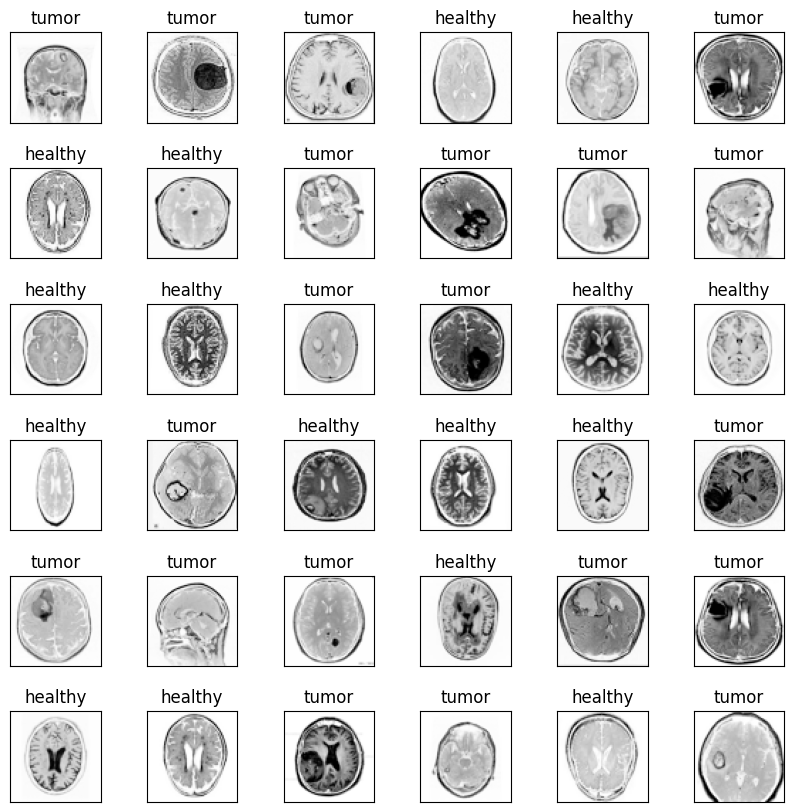

In [9]:
NUM_DISPLAY = 36
images = X_train[:NUM_DISPLAY, :]
titles = [LABEL_MAP[Y_train[i, 0]] for i in range(NUM_DISPLAY)]
visualize_images(images=images, titles=titles)

In [10]:
visualize_table(X=X_train, Y=Y_train, num_display=NUM_DISPLAY)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel4086,pixel4087,pixel4088,pixel4089,pixel4090,pixel4091,pixel4092,pixel4093,pixel4094,pixel4095
label,,,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,1,1,1,1,1,...,2,1,1,1,1,1,1,1,1,0
1,2,2,2,2,2,2,1,3,3,2,...,3,5,3,2,1,1,2,2,2,2
1,54,54,53,53,53,53,53,53,53,53,...,10,11,11,11,11,11,11,10,8,120
0,0,0,0,0,0,0,0,0,0,0,...,3,4,3,4,3,6,4,4,5,3
0,13,13,16,16,16,16,16,14,13,13,...,13,13,13,13,13,13,13,13,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,1,1,1,1,1,1,0,2,3,...,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,16,27,29,30,31,31,32,32,31,24
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
MIN_VALUE = np.min(X_train)
MAX_VALUE = np.max(X_train)
X_train = np.float32(X_train / (MAX_VALUE - MIN_VALUE))
X_val = np.float32(X_val / (MAX_VALUE - MIN_VALUE))
X_test = np.float32(X_test / (MAX_VALUE - MIN_VALUE))

In [12]:
visualize_table(X=X_train, Y=Y_train, num_display=NUM_DISPLAY)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel4086,pixel4087,pixel4088,pixel4089,pixel4090,pixel4091,pixel4092,pixel4093,pixel4094,pixel4095
label,,,,,,,,,,,,,,,,,,,,,
1.0,0.000000,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.007843,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.000000
1.0,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.003922,0.011765,0.011765,0.007843,...,0.011765,0.019608,0.011765,0.007843,0.003922,0.003922,0.007843,0.007843,0.007843,0.007843
1.0,0.211765,0.211765,0.207843,0.207843,0.207843,0.207843,0.207843,0.207843,0.207843,0.207843,...,0.039216,0.043137,0.043137,0.043137,0.043137,0.043137,0.043137,0.039216,0.031373,0.470588
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.011765,0.015686,0.011765,0.015686,0.011765,0.023529,0.015686,0.015686,0.019608,0.011765
0.0,0.050980,0.050980,0.062745,0.062745,0.062745,0.062745,0.062745,0.054902,0.050980,0.050980,...,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.0,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.000000,0.007843,0.011765,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.062745,0.105882,0.113725,0.117647,0.121569,0.121569,0.125490,0.125490,0.121569,0.094118
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
onehot_Y_train = onehot_encode(Y=Y_train, C=C)
onehot_Y_val = onehot_encode(Y=Y_val, C=C)
onehot_Y_test = onehot_encode(Y=Y_test, C=C)

In [14]:
nnModel = NN.NeuralNetModel()

### Training

Single-layer Neural Network

(2837, 4096) (710, 4096) (887, 4096)
(2837, 2) (710, 2) (887, 2)
Training your 1-layer neural net...
Epoch 0, train loss=0.6268, val loss=0.5669, duration=13.0301s
Epoch 0, train loss=0.6268, val loss=0.5669, duration=13.0301s
Epoch 1, train loss=0.5358, val loss=0.5070, duration=12.6948s
Epoch 1, train loss=0.5358, val loss=0.5070, duration=12.6948s
Epoch 2, train loss=0.4787, val loss=0.4622, duration=12.7384s
Epoch 2, train loss=0.4787, val loss=0.4622, duration=12.7384s
Epoch 3, train loss=0.4315, val loss=0.4236, duration=12.6981s
Epoch 3, train loss=0.4315, val loss=0.4236, duration=12.6981s
Epoch 4, train loss=0.3892, val loss=0.3893, duration=12.7317s
Epoch 4, train loss=0.3892, val loss=0.3893, duration=12.7317s
Epoch 5, train loss=0.3502, val loss=0.3591, duration=12.6754s
Epoch 5, train loss=0.3502, val loss=0.3591, duration=12.6754s
Epoch 6, train loss=0.3139, val loss=0.3327, duration=12.6332s
Epoch 6, train loss=0.3139, val loss=0.3327, duration=12.6332s
Epoch 7, train lo

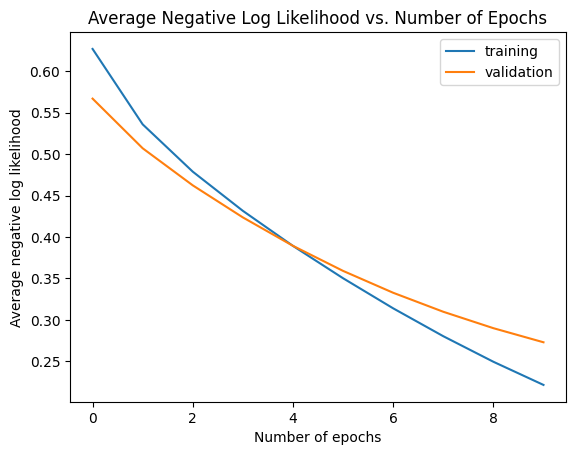

In [15]:
D1 = 128
num_epochs = 10
lr = 0.001

print(X_train.shape, X_val.shape, X_test.shape)
print(onehot_Y_train.shape, onehot_Y_val.shape, onehot_Y_test.shape)

print('Training your 1-layer neural net...')
nn1layer_output = nnModel.trainSLNN(X_train=X_train, 
                                 Y_train=onehot_Y_train, 
                                 X_val=X_val, 
                                 Y_val=onehot_Y_val, 
                                 Layer1_neurons=D1,
                                 num_epochs=num_epochs, 
                                 lr=lr)

print('Plotting loss vs. epoch graphs...')
num_epochs_lst = [i for i in range(num_epochs)]
plot_losses(num_epochs=num_epochs_lst, 
            train_losses=nn1layer_output['train_losses'], 
            val_losses=nn1layer_output['val_losses'])

nnModel.save_model('SLNNmodel.pkl')

Double-layer Neural Network

Training your 2-layer neural net...
Epoch 0, train loss=0.6547, val loss=0.6142, duration=13.2975s
Epoch 1, train loss=0.5795, val loss=0.5451, duration=13.3119s
Epoch 2, train loss=0.5133, val loss=0.4908, duration=12.9672s
Epoch 3, train loss=0.4578, val loss=0.4454, duration=12.9686s
Epoch 4, train loss=0.4070, val loss=0.4050, duration=12.9062s
Epoch 5, train loss=0.3593, val loss=0.3704, duration=12.9132s
Epoch 6, train loss=0.3140, val loss=0.3410, duration=12.9670s
Epoch 7, train loss=0.2712, val loss=0.3165, duration=13.3046s
Epoch 8, train loss=0.2313, val loss=0.2972, duration=13.2006s
Epoch 9, train loss=0.1951, val loss=0.2820, duration=12.9028s
Plotting loss vs. epoch graphs...


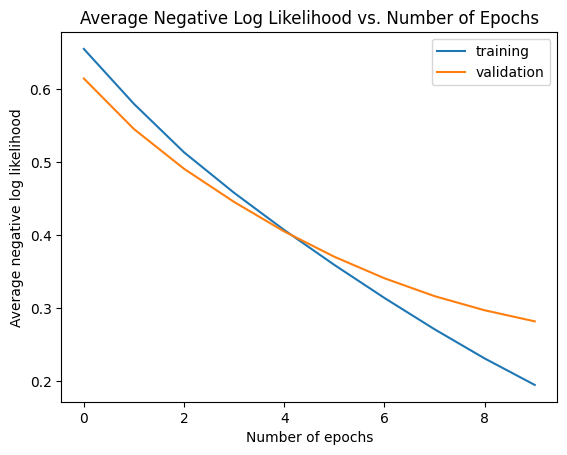

In [16]:
D1, D2 = 128, 64
num_epochs = 10
lr = 0.001

print('Training your 2-layer neural net...')
nn2layer_output = nnModel.trainDLNN(X_train=X_train, 
                                 Y_train=onehot_Y_train, 
                                 X_val=X_val, 
                                 Y_val=onehot_Y_val, 
                                 Layer1_neurons=D1,
                                 Layer2_neurons=D2,
                                 num_epochs=num_epochs, 
                                 lr=lr)

print('Plotting loss vs. epoch graphs...')
num_epochs_lst = [i for i in range(num_epochs)]
plot_losses(num_epochs=num_epochs_lst, 
            train_losses=nn2layer_output['train_losses'], 
            val_losses=nn2layer_output['val_losses'])

nnModel.save_model('DLNNmodel.pkl')

In [17]:
print('Making predictions...')

nnModel.load_model('DLNNmodel.pkl')

Y_hat_train_2 = nnModel.predictDouble(
    X=X_train
)
Y_hat_val_2 = nnModel.predictDouble(
    X=X_val
)
Y_hat_test_2 = nnModel.predictDouble(
    X=X_test
)

print('Getting accuracies...')
train_accuracy_2 = 1 - NN.CoreFunctions.errorRate(Y_train, Y_hat_train_2['labels'])
val_accuracy_2 = 1 - NN.CoreFunctions.errorRate(Y_val, Y_hat_val_2['labels'])
test_accuracy_2 = 1 - NN.CoreFunctions.errorRate(Y_test, Y_hat_test_2['labels'])

print('accuracy on train = %0.2f %%' % (100*train_accuracy_2))
print('accuracy on val = %0.2f %%' % (100*val_accuracy_2))
print('accuracy on test = %0.2f %%' % (100*test_accuracy_2))

Making predictions...
Getting accuracies...
accuracy on train = 96.05 %
accuracy on val = 89.72 %
accuracy on test = 90.42 %


In [18]:
print('Making predictions...')

nnModel.load_model('SLNNmodel.pkl')

Y_hat_train = nnModel.predictSingle(X_train)
Y_hat_val = nnModel.predictSingle(X_val)
Y_hat_test = nnModel.predictSingle(X_test)

print('Getting accuracies...')
train_accuracy = 1 - NN.CoreFunctions.errorRate(Y_train, Y_hat_train['labels'])
val_accuracy = 1 - NN.CoreFunctions.errorRate(Y_val, Y_hat_val['labels'])
test_accuracy = 1 - NN.CoreFunctions.errorRate(Y_test, Y_hat_test['labels'])

print('accuracy on train = %0.2f %%' % (100*train_accuracy))
print('accuracy on val = %0.2f %%' % (100*val_accuracy))
print('accuracy on test = %0.2f %%' % (100*test_accuracy))

Making predictions...
Getting accuracies...
accuracy on train = 95.45 %
accuracy on val = 90.56 %
accuracy on test = 90.42 %
Getting accuracies...
accuracy on train = 95.45 %
accuracy on val = 90.56 %
accuracy on test = 90.42 %


### Visualizing Predictions

C:\Users\aadip\AppData\Local\Temp\ipykernel_34620\617743024.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"Pred: {LABEL_MAP[int(pred_label)]}", fontsize=8)


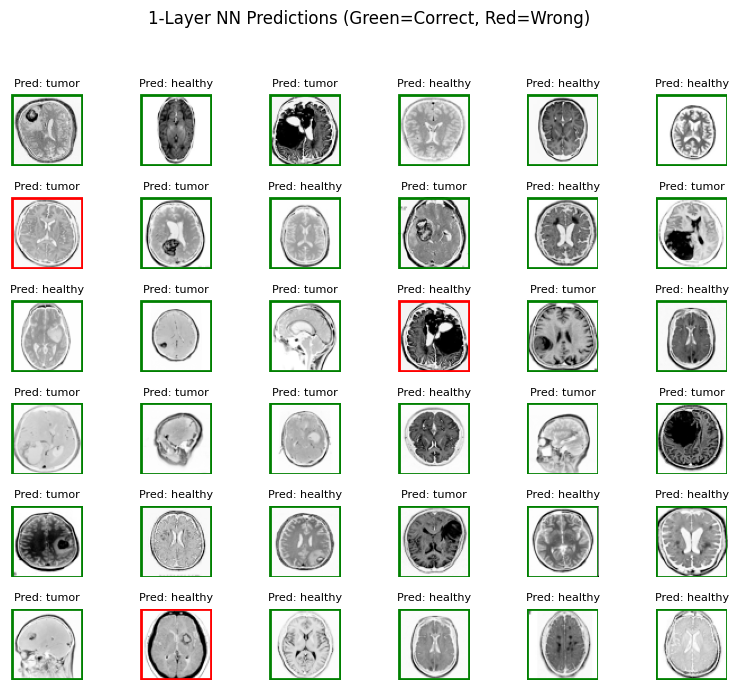

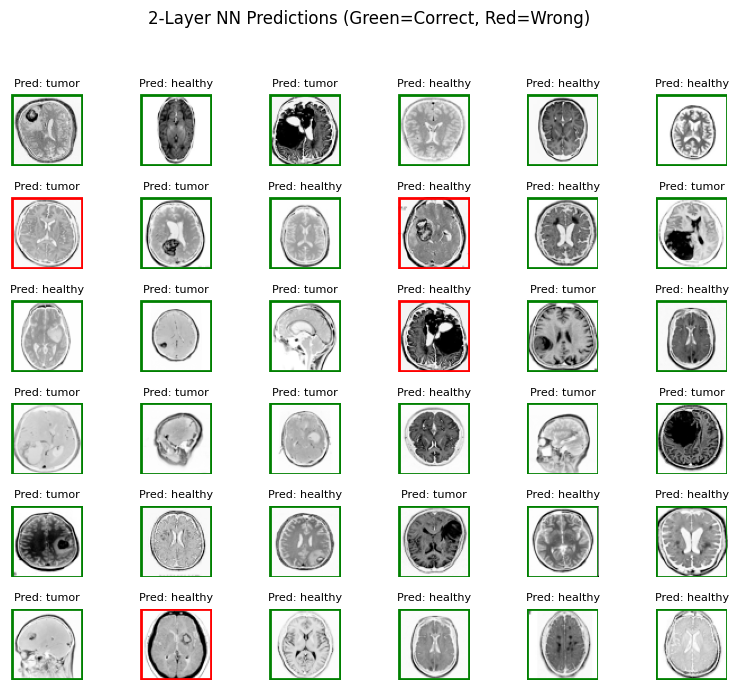

In [19]:
import matplotlib.patches as patches
def visualize_predictions(X, Y_true, Y_pred, LABEL_MAP, num_display=25, title_prefix="", fig_size=(8, 7)):
    plt.figure(figsize=fig_size)
    num_cells = int(np.ceil(np.sqrt(num_display)))
    for i in range(num_display):
        ax = plt.subplot(num_cells, num_cells, i + 1)
        image = X[i].reshape(pixels, pixels)
        true_label = Y_true[i, 0] if Y_true.ndim == 2 else Y_true[i]
        pred_label = Y_pred[i][0] if Y_pred[i].ndim > 1 else Y_pred[i]
        correct = (true_label == pred_label)
        cmap = 'Greys'
        ax.imshow(image, cmap=cmap)
        ax.set_title(f"Pred: {LABEL_MAP[int(pred_label)]}", fontsize=8)
        
        color = 'green' if correct else 'red'
        rect = patches.Rectangle((0,0),pixels-1,pixels-1,linewidth=2,edgecolor=color,facecolor='none')
        ax.add_patch(rect)
        ax.axis('off')
    plt.suptitle(title_prefix + " Predictions (Green=Correct, Red=Wrong)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

visualize_predictions(X_test, Y_test, Y_hat_test['labels'], LABEL_MAP, num_display=NUM_DISPLAY, title_prefix="1-Layer NN")

visualize_predictions(X_test, Y_test, Y_hat_test_2['labels'], LABEL_MAP, num_display=NUM_DISPLAY, title_prefix="2-Layer NN")